In [1]:
import sys
sys.path.append("..")

import pickle

import torch
from sklearn.model_selection import train_test_split

import fastai
from fastai.basics import Learner, DataLoaders
from fastai.vision.all import *
from fastai.callback.all import *
from fastai.torch_core import trainable_params

# from Utils.model_datasets import RPIDataset
from Utils.model_utils import LossLogger
from Utils.model_datasets import EncodedRPIDataset
from Utils.model_blocks import *
from Utils.train import set_seed, main_model_splitter, BlockInputShapeReformatter, MainModelDenseInputSizeCalculator

import nni
from torch import nn

In [2]:
def determine_block_name_from_params(params):
    """
    Searches for a parameter exclusive to a different block type
    within the given parameters, and returns the corresponding
    block name. 
    """
    
    param_names = params.keys()
    if 'pooling_type' in param_names:
        return 'ConvPool'
    elif 'reccurent_type' in param_names:
        return 'Reccurent'
    elif 'layer_count' in param_names:
        return 'Attention'
    elif 'hidden_sizes' in param_names:
        return 'StackedRes'
    elif 'hidden_layer_sizes' in param_names:
        return 'Dense'
    elif 'sae_type' in param_names:
        return 'SAE'

def swap_seq_input_order(data : list) -> None:
    seq1, seq2 = data[0], data[1]
    data[0] = seq2
    data[1] = seq1

def initiate_lr_option(lr_option, lr_min, lr_steep):
    "having min first is intentional. It results in better performance"
    options = {'slice' : slice(lr_min, lr_steep), 'min' : lr_min}
    return options[lr_option]

In [3]:
# def none_string_corrector(parameters):
#     for key,value in parameters.items():
#         if type(key) == dict:
#             none_string_corrector(value[key])
#         elif value == 'None':
#             parameters[key] = None

In [4]:
# initializer = BlockInializer(255)
# x = "**{'act': 'nn.ReLU()', act_cls': 'nn.LeakyReLU', 'bn_first': True}"
# initializer._reformat_block_act(x)

In [5]:
# Reccurent
# ---
# PARAMS = {
#     # Main model/misc params,
#     "batchsize": 32,
#     "dense_hidden_layers": [3000,1000,100],
#     "p": 0.2,
#     "act": 'nn.LeakyReLU()',
#     "bn" : True,
#     "lin_first" : False,
#     #RNA Params,
#     "rna_reccurent_type": 'GRU',
#     "rna_bidirectional": True,
#     "rna_dropout": 0.2,
#     "rna_num_layers": 3,
#     "rna_hidden_size": 32,
#     #Prot Params,
#     "prot_reccurent_type": 'GRU',
#     "prot_bidirectional": True,
#     "prot_dropout": 0.2,
#     "prot_num_layers": 2,
#     "prot_hidden_size": 64
# }

# Attention
# ---
# PARAMS = {
#     "batchsize": 64,
#     "dense_hidden_layers": [5000,3000,1000,500,100,50],
#     "p": 0.2,
#     "act":'nn.LeakyReLU()',
#     "bn" : True,
#     "lin_first" : False,
#     #RNA Params
#     "rna_layer_count": 10,
#     #Prot Params
#     "prot_layer_count": 10
# }

# Dense
# # ---
# PARAMS = {
#     "batchsize": 64,
#     "dense_hidden_layers": [5000,3000,1000,500,100,50],
#     "p": 0.2,
#     "act":'nn.LeakyReLU()',
#     "bn" : True,
#     "lin_first" : False,
#     #RNA Params
#     "rna_hidden_layer_sizes": [800,600,400,200],
#     "rna_p": 0.2,
#     "rna_act":'nn.LeakyReLU()',
#     "rna_bn" : True,
#     "rna_lin_first" : False,
#     #Prot Params
#     "prot_hidden_layer_sizes": [800,600,400,200],
#     "prot_p": 0.2,
#     "prot_act":'nn.LeakyReLU()',
#     "prot_bn" : True,
#     "prot_lin_first" : False
# }

# StackedRes
# ---
# PARAMS = {
#     "batchsize": 64,
#     "dense_hidden_layers": [5000,3000,1000,500,100,50],
#     "p": 0.2,
#     "act":'nn.LeakyReLU()',
#     "bn" : True,
#     "lin_first" : False,
#     #RNA Params
#     "rna_hidden_sizes": [80,60,40],
#     'rna_expansion': 1,
#     'rna_act_cls' : 'nn.LeakyReLU',
#     "rna_bn_1st" : True,
#     #Prot Params
#     "prot_hidden_sizes": [80,60,40],
#     "prot_expansion": 1,
#     'prot_act_cls' : 'nn.LeakyReLU',
#     "prot_bn_1st" : True
# }

########## TEST ######################
# PARAMS = {"batchsize":16,
# "dense_hidden_layers": [2000,1000,20],
# "p":0.5,
# "act":"nn.Sigmoid()",
# "bn":False,
# "lin_first":False,
# "lr_max_arg":"min",
# "rna_hidden_sizes":[82,64,46,28,10],
# "rna_act_cls":'None',
# "rna_bn_1st":False,
# "prot_hidden_sizes": [70,40,10],
# "prot_act_cls":"nn.ReLU",
# "prot_bn_1st":True}

# ConvPool
# ---
PARAMS = {
    "batchsize": 32,
    "dense_hidden_layers": [5000,3000,1000,500,100,50],
    "p": 0.2,
    "act":'nn.LeakyReLU()',
    "bn" : True,
    "lin_first" : True,
    #RNA Params
    "rna_act_cls": "nn.ReLU",
    "rna_conv_channel_sizes": [100,60,20],
    "rna_pooling_kernel_sizes": 2,
    "rna_bn_1st": True,
    "rna_ks": 3,
    "rna_pooling_type":"mixed",
    #Prot params
    "prot_act_cls": "nn.ReLU",
    "prot_conv_channel_sizes": [112,66,20],
    "prot_pooling_kernel_sizes": 2,
    "prot_bn_1st": True,
    "prot_ks":3,
    "prot_pooling_type": "mixed"
}

# DenseSAE
# ---
# PARAMS = {
#     "batchsize": 64,
#     "dense_hidden_layers": [5000,3000,1000,500,100,50],
#     "p": 0.2,
#     "act":'nn.LeakyReLU()',
#     "bn" : True,
#     "lin_first" : False,
#     #RNA Params
#     "rna_sae_type": "Dense",
#     "rna_sae_model_path": "/data/Chapter_3/Notebooks/rnavec_encoded_aggregated_u_t_swapped_rnas_DenseSAE.pt",
#     #Prot Params
#     "prot_sae_type": "Dense",
#     "prot_sae_model_path": '/data/Chapter_3/Notebooks/ProtBERT_encoded_110_swissprot_DenseSAE.pt',
# }

############### TRY LATER ###############
# ConvSAE 
# ---
# PARAMS = {
#     "batchsize": 64,
#     "dense_hidden_layers": [5000,3000,1000,500,100,50],
#     "p": 0.2,
#     "act":'nn.LeakyReLU()',
#     "bn" : True,
#     "lin_first" : False,
#     # RNA Params
#     "rna_sae_type": "Convolutional",
#     "rna_sae_model_path": X,
#     # Prot Params
#     "prot_sae_type": "Convolutional",
#     "prot_sae_model_path": X,
# }

In [6]:
###################################################
# Set constants
###################################################
SEED = 255

BATCHSIZE = PARAMS.pop("batchsize")
MAIN_ACT = eval(PARAMS.pop("act"))

main_model_params = {key : value for key,value in PARAMS.items() if 'rna' not in key and 'prot' not in key}
rna_block_params = {key.replace("rna_","") : value for key,value in PARAMS.items() if 'rna' in key}
prot_block_params = {key.replace("prot_","") : value for key,value in PARAMS.items() if 'prot' in key}

rna_block_name = determine_block_name_from_params(rna_block_params)
prot_block_name = determine_block_name_from_params(prot_block_params)

# TEMPORARY: ASSUMES THAT PROT AND RNA BLOCKS ARE IDENTICAL
block_name = prot_block_name
print(block_name)

ConvPool


In [7]:
rna_block_params

{'act_cls': 'nn.ReLU',
 'conv_channel_sizes': [100, 60, 20],
 'pooling_kernel_sizes': 2,
 'bn_1st': True,
 'ks': 3,
 'pooling_type': 'mixed'}

In [8]:
prot_block_params

{'act_cls': 'nn.ReLU',
 'conv_channel_sizes': [112, 66, 20],
 'pooling_kernel_sizes': 2,
 'bn_1st': True,
 'ks': 3,
 'pooling_type': 'mixed'}

In [9]:
#####################################################
# Load training data
######################################################
if block_name == 'ConvPool':
    with open("../Data/TrainingData/ReducedEmbeddedTrainingData_2D.pickle",'rb') as handle:
        data = pickle.load(handle)
else:
    with open("../Data/TrainingData/ReducedEmbeddedTrainingData.pickle",'rb') as handle:
        data = pickle.load(handle)

train_idx, val_idx = train_test_split(range(len(data[0])), random_state = SEED, test_size = 0.2, 
                                       stratify = data[-1])

train_data, val_data = zip(*[(X[train_idx], X[val_idx]) for X in data])

shape_reformatter = BlockInputShapeReformatter()

train_data = [shape_reformatter.reformat_input(block_name, train_data[i]) for i in range(2)] + [train_data[-1]]
val_data = [shape_reformatter.reformat_input(block_name, val_data[i]) for i in range(2)] + [val_data[-1]]

# The training data currently in this order: prot,rna,interaction
# MainModel needs the rna input before the protein inputs, so the swap is necessary
swap_seq_input_order(train_data)
swap_seq_input_order(val_data)

train_dataset = EncodedRPIDataset(train_data)
val_dataset = EncodedRPIDataset(val_data)

del data, train_data, val_data

In [10]:
# import yaml

# with open("../config.yaml") as handle:
#     x = yaml.load(handle, Loader = yaml.FullLoader)

In [11]:
# none_string_corrector(PARAMS)

In [12]:
# rna_block_params

In [13]:
class BlockInializer:
    """
    Used to initialize MainModel blocks from the parameters and 
    """
    
    def __init__(self, seed):
        self.seed = seed
    
    def _reformat_block_act(self, block_params):
        preprocessed_block_str = re.sub(r"'act': 'nn.(.+?)\(\)'", r"'act': nn.\1()", block_params)
        preprocessed_block_str = re.sub(r"'act_cls': 'nn.(.+?)\'", r"'act_cls': nn.\1", preprocessed_block_str)
        return preprocessed_block_str
    
    def generate_block_str(self, block_name, input_size, block_params):
        return f"{block_name}Block({input_size}, **{block_params})"
    
    def _reformat_sae_block(self, input_size, preprocessed_block_str):
        return preprocessed_block_str.replace(f"{input_size}, ","")
    
    ######################################################################
    # COME BACK HERE WHEN REFRESHED #
    
    def _remove_params_from_block_params_present_in_kwargs_dict(self, block_params : dict, kwargs_dict : dict) -> None:
        "Intentionally doesn't return a value, just iterates a process to pop dict items"
        [block_params.pop(key) for key in kwargs_dict.keys()]
    
    def _generate_conv_kwargs_str(self, block_params):
        conv_kwargs = {key : value for key,value in block_params.items() if key in ['bn_1st','ks','act_cls']}
        self._remove_params_from_block_params_present_in_kwargs_dict(block_params, conv_kwargs)
        return f"conv_kwargs = {conv_kwargs}"
    
    def _generate_pool_kwargs_str(self, block_params):
        "FILL THIS LIST IN EVENTUALLY"
        pool_kwargs = {key : value for key,value in block_params.items() if key in list()}
        self._remove_params_from_block_params_present_in_kwargs_dict(block_params, pool_kwargs)
        return f"pool_kwargs = {pool_kwargs}"
    
#     def _reformat_convpool_block_inputsize(self, preprocessed_block_str, input_size, block_params):
#         return preprocessed_block_str.replace(f"{input_size}, ",f"{block_params['conv_channel_sizes']},")
    
    def _generate_convpool_str(self, block_params, conv_kwargs, pool_kwargs):
        conv_channel_sizes = block_params.pop('conv_channel_sizes')
        return f"ConvPoolBlock({conv_channel_sizes}, {conv_kwargs}, {pool_kwargs}, **{block_params})"
    
    def _reformat_convpool_block(self, preprocessed_block_str, block_params):
        conv_kwargs = self._generate_conv_kwargs_str(block_params)
        pool_kwargs = self._generate_pool_kwargs_str(block_params)
        conv_block_str = self._generate_convpool_str(block_params, conv_kwargs, pool_kwargs)
        conv_block_str = self._reformat_block_act(conv_block_str)
        return conv_block_str
    ######################################################################
    
    def initialize_block(self, block_name, input_size, block_params):
        block_str = self.generate_block_str(block_name, input_size, block_params)
        preprocessed_block_str = self._reformat_block_act(block_str)
        
        if block_name == 'SAE':
            preprocessed_block_str = self._reformat_sae_block(input_size, preprocessed_block_str)
        if block_name == 'ConvPool':
            preprocessed_block_str = self._reformat_convpool_block(preprocessed_block_str, block_params)
        
        set_seed(self.seed)
        print(preprocessed_block_str)
        return eval(preprocessed_block_str)

In [14]:
#####################################################
# Initialize model blocks and dense input size
#####################################################
block_initializer = BlockInializer(SEED)
rna_block = block_initializer.initialize_block(rna_block_name, 1024, rna_block_params)
prot_block = block_initializer.initialize_block(prot_block_name, 1024, prot_block_params)

ConvPoolBlock([100, 60, 20], conv_kwargs = {'act_cls': nn.ReLU, 'bn_1st': True, 'ks': 3}, pool_kwargs = {}, **{'pooling_kernel_sizes': 2, 'pooling_type': 'mixed'})
ConvPoolBlock([112, 66, 20], conv_kwargs = {'act_cls': nn.ReLU, 'bn_1st': True, 'ks': 3}, pool_kwargs = {}, **{'pooling_kernel_sizes': 2, 'pooling_type': 'mixed'})


In [15]:
#####################################################
# Calculate dense input size
#####################################################

dense_input_calculator = MainModelDenseInputSizeCalculator(train_dataset[:2][0], train_dataset[:2][1])

dense_input_size = dense_input_calculator.calcualte_input_shape(rna_blocks  = [rna_block.cpu()], 
                                                                prot_blocks = [prot_block.cpu()])

In [16]:
# def main_model_splitter_1(model : MainModel) -> list:
#     """
#     Splits the module in such a way where the RNA and Prot blocks
#     have identical lrs. The dense and final blocks, however, are
#     split by layer. 
#     """
    
#     rna_module_params   = trainable_params(model.blocks['rna'])
#     prot_module_params  = trainable_params(model.blocks['prot'])
    
#     dense_module_params = trainable_params(model.dense) + trainable_params(model.final)
    
#     splitter_output = [rna_module_params+prot_module_params,
#                        dense_module_params]
    
#     return splitter_output

######################################
# This splitter is the best performing
######################################
# def main_model_splitter_2(model : MainModel) -> list:
#     """
#     Splits the module in such a way where the RNA and Prot blocks
#     have identical lrs. The dense and final blocks, however, are
#     split by layer. 
#     """
    
#     rna_module_params   = trainable_params(model.blocks['rna'])
#     prot_module_params  = trainable_params(model.blocks['prot'])
    
#     dense_module_params = trainable_params(model.dense) + trainable_params(model.final)
    
#     splitter_output = [rna_module_params+prot_module_params,
#                        *dense_module_params]
    
#     return splitter_output

# def main_model_splitter_3(model : MainModel) -> list:
#     """
#     Splits the module in such a way where the RNA and Prot blocks
#     have identical lrs. The dense and final blocks, however, are
#     split by layer. 
#     """
    
#     rna_module_params   = trainable_params(model.blocks['rna'])
#     prot_module_params  = trainable_params(model.blocks['prot'])
    
#     dense_module_params = trainable_params(model.dense) + trainable_params(model.final)
    
#     splitter_output = [[rna_module_params,prot_module_params],
#                        dense_module_params]
    
#     return splitter_output

# def main_model_splitter_4(model : MainModel) -> list:
#     """
#     Splits the module in such a way where the RNA and Prot blocks
#     have identical lrs. The dense and final blocks, however, are
#     split by layer. 
#     """
    
#     rna_module_params   = trainable_params(model.blocks['rna'])
#     prot_module_params  = trainable_params(model.blocks['prot'])
    
#     dense_module_params = trainable_params(model.dense) + trainable_params(model.final)
    
#     splitter_output = [rna_module_params,prot_module_params,
#                        *dense_module_params]
    
#     return splitter_output

# def main_model_splitter_5(model : MainModel) -> list:
#     """
#     Splits the module in such a way where the RNA and Prot blocks
#     have identical lrs. The dense and final blocks, however, are
#     split by layer. 
#     """
    
#     rna_module_params   = trainable_params(model.blocks['rna'])
#     prot_module_params  = trainable_params(model.blocks['prot'])
    
#     dense_module_params = trainable_params(model.dense) + trainable_params(model.final)
    
#     splitter_output = [prot_module_params,rna_module_params,
#                        *dense_module_params]
    
#     return splitter_output

epoch,train_loss,valid_loss,time
0,0.472697,0.681923,00:12
1,0.425208,0.382422,00:12
2,0.420869,0.353132,00:12
3,0.418910,0.371154,00:12
4,0.395466,0.371765,00:12
5,0.396771,0.377067,00:12
6,0.413912,0.375226,00:13
7,0.389953,0.366069,00:13
8,0.408135,0.378000,00:13
9,0.386102,0.367058,00:13


No improvement since epoch 2: early stopping


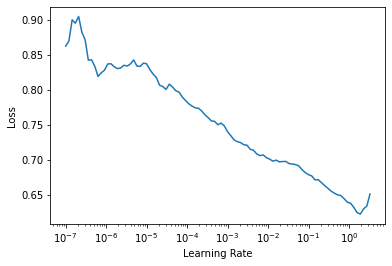

In [17]:
#####################################################
# Generate and train model
#####################################################
# rna_block = block_initializer.initialize_block(rna_block_name, 1024, rna_block_params)
# prot_block = block_initializer.initialize_block(prot_block_name, 1024, prot_block_params)

set_seed(255)
main_model = MainModel(rna_blocks  = [rna_block],
                       prot_blocks = [prot_block],
                       dense_input_size = dense_input_size,
                       act = MAIN_ACT,
                       **main_model_params).cuda()

# 1: exteremely unstable
# 2: lowers until 10 min: 0.594110 (epoch 9)
# 3: N/A
# 4: N/A

# trainable_params: Consistantly lowers (min 0.50)
set_seed(255)
loaders = DataLoaders.from_dsets(train_dataset, val_dataset,
                                 bs = BATCHSIZE,
                                 device = 0)

learner = Learner(loaders, main_model,
                  splitter = main_model_splitter,
                  cbs = [EarlyStoppingCallback(patience = 10)],
                  loss_func = nn.BCELoss())

lr_min, lr_steep = learner.lr_find()

LR_OPTION = 'slice'
max_lr_arg = initiate_lr_option(LR_OPTION, lr_min, lr_steep)
learner.fit_one_cycle(100, lr_max = max_lr_arg)

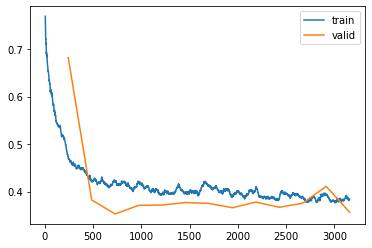

In [18]:
learner.recorder.plot_loss()

In [19]:
###################################################
# Acquire min val loss and report it to nni
###################################################
_, val_loss  = zip(*learner.recorder.values)
min_val_loss = min(val_loss)
print(round(min_val_loss,4))
# nni.report_final_result(min_val_loss)

0.3531
